```
Author : Javier Chiyah-Garcia
GitHub : https://github.com/JChiyah/what-are-you-referring-to
Date   : August 2023
Python : 3.7+
```

Notebook with experiments for the paper __'What are you referring to?' Evaluating the Ability of Multi-Modal Dialogue Models to Process Clarificational Exchanges__

You need to have cloned this repository, as well as the SIMMC2 original repository, as it uses the original dataset from there to find the clarifications. We also provide the analysed model outputs in a separate folder, so you can run the evaluation without having to train the models yourself.

Some values may differ than those from the paper, as we have improved the tagging algorithm and fixed some bugs in the code ('All Turns' split was skipping turns that did not have a target). The results are very similar, somewhat lower across all models by a few decimals.

Requirements:
- Python 3.7 or above
- Numpy
- Tqdm

In [15]:
%load_ext autoreload
%autoreload 2

import os
import sys
import json
import glob
from importlib import reload

from tqdm import tqdm

# we assume that the simmc2 data is just outside the current folder (sibling dir)
sys.path.append('../')
# imported here to make sure it works, but used in evaluation.py
from simmc2.model.mm_dst.utils.evaluate_dst import evaluate_from_flat_list
SIMMC2_FOLDER = '../simmc2/data'

from src import *

# read original SIMMC 2.0 data
simmc2_metadata = {}
for domain in tqdm(['fashion', 'furniture'], desc='Reading Metadata'):
	with open(os.path.join(SIMMC2_FOLDER, f"{domain}_prefab_metadata_all.json"), 'r') as f_in:
		simmc2_metadata = {**simmc2_metadata, **json.load(f_in)}

simmc2_scenes_jsons ={}
_files = glob.glob(f"{SIMMC2_FOLDER}/simmc2_scene_jsons_dstc10_public/*.json")
for file in tqdm(_files, desc='  JSON scenes'):
	with open(file, "r") as f_in:
		simmc2_scenes_jsons[os.path.splitext(os.path.basename(file))[0]] = json.load(f_in)


Reading Metadata: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 688.66it/s]
  JSON scenes: 0it [00:00, ?it/s]


In [2]:
def read_dataset(split):
	with open(os.path.join(SIMMC2_FOLDER, f"simmc2_dials_dstc10_{split}.json"), 'r') as f_in:
		return json.load(f_in)

train_dataset = read_dataset('train')
dev_dataset = read_dataset('dev')
devset_dataset = read_dataset('devtest')

DATASET_SPLIT = 'devtest'
# simmc2_dataset = join_dataset_splits([train_dataset, dev_dataset, devset_dataset])
simmc2_dataset = devset_dataset

In [3]:
DATA_FOLDER = 'data'

# read model output files
model_outputs = {}

for subdir, dirs, files in os.walk(DATA_FOLDER):
	if 'coref-pred-devtest-mini.json' in files:
		with open(f"{subdir}/coref-pred-devtest-mini.json", 'r') as f_in:
			model_name = subdir.split('/')[-1]
			model_outputs[model_name] = json.load(f_in)
			# make sure that the dialogues have at most 1 turn (it's a specific format from SIMMC2 challenge)
			for dialogue in model_outputs[model_name]['dialogue_data'][:3]:
				if len(dialogue['dialogue']) > 1:
					# we need to fix this dataset!
					model_outputs[model_name] = fix_prediction_data_format(model_outputs[model_name])
					break

# sort dictionary by key
model_outputs = dict(sorted(model_outputs.items(), key=lambda item: item[0]))

# This is another variant of the Baseline GPT-2 from the challenge without the MultiModal help
del model_outputs['Baseline_GPT2_noMM']		# ignore for now
# We process the output of this model, but Team9 skipped predictions for ambiguous (Before-CR) turns and
# that needs to be changed in their original code. We left here for comparing All and After-CR turns
del model_outputs['Team9']

all_models = list(model_outputs.keys())
print(f"Loaded outputs: {all_models}")

Loaded outputs: ['1-Baseline_GPT2', '2-GroundedLan_GPT2', '3-VisLan_LXMERT', '4-MultiTask_BART']


In [4]:
# do some pre-processing on the original simmc2 data
last_ambiguous_turn = None

clarification_exchanges = []

# we can iterate the original data easily, but the model output data is formatted
# in a slightly different way, so we need the t_index to access the turn
print('Preprocessing dataset and printing example Clarification Exchanges (CEs)')
for t_index, simmc2_datum in enumerate(iterate_over_dataset_entries(simmc2_dataset)):
	simmc2_dialogue, simmc2_turn = simmc2_datum
	simmc2_turn['model_outputs'] = {}
	simmc2_turn['scene_idx'], simmc2_turn['previous_scene_idx'] = get_scene_idx(
		simmc2_dialogue['scene_ids'], simmc2_turn['turn_idx'])

	for model_name, model_output in model_outputs.items():
		pred_dialogue = model_output['dialogue_data'][t_index]
		pred_turn = pred_dialogue['dialogue'][0]	# in model outputs, there is at most 1 turn per dialogue

		# check that we are in the same dialogue and turn in all the model outputs
		assert simmc2_dialogue['dialogue_idx'] == pred_dialogue['dialogue_idx'] \
			and simmc2_turn['turn_idx'] == pred_turn['turn_idx'], \
			f"Model output {model_name} does not match the original SIMMC2 data: " \
			f"Dialogue {simmc2_dialogue['dialogue_idx']} Turn {simmc2_turn['turn_idx']} " \
			f"Dialogue {pred_dialogue['dialogue_idx']} Turn {pred_turn['turn_idx']}"

		# add the model output to the turn as 'synced' or joint data
		simmc2_turn['model_outputs'][model_name] = pred_turn

	# check for Clarification Exchanges
	if ce.is_ambiguous_turn(simmc2_turn):
		last_ambiguous_turn = simmc2_dialogue, simmc2_turn
	elif last_ambiguous_turn is not None:
		# this is the turn after the CR, make sure they are the same dialogue
		if last_ambiguous_turn[0]['dialogue_idx'] == simmc2_dialogue['dialogue_idx']:
			ce.mark_clarification_exchange(
				ambiguous_turn=last_ambiguous_turn[1], response_turn=simmc2_turn)
			clarification_exchanges.append(last_ambiguous_turn[1]['ce'])
		last_ambiguous_turn = None

	# last_ambiguous_turn = None	# reset for new dialogues, probs redundant

Preprocessing dataset and printing example Clarification Exchanges (CEs)
  Clarification Exchange
	USR: Does the grey have good reviews? | ['colour', 'individual_property']
	SYS: Which one do you mean? | []
	USR: The grey one on the hanging rack. | ['colour', 'individual_property', 'property', 'relational', 'relational_context']
	SYS: That dress has a high rating at 4.3.
	Tags=['colour', 'individual_property', 'property', 'relational', 'relational_context']
  Clarification Exchange
	USR: What size is the pair on the left and who makes it? | ['relational_context', 'spatial']
	SYS: Sorry, which one? | []
	USR: The jeans on the left. | ['individual_property', 'relational_context', 'spatial', 'type']
	SYS: It's a size L,  from Cats Are Great.
	Tags=['individual_property', 'relational_context', 'spatial', 'type']
  Clarification Exchange
	USR: Can you tell me who makes it and how much it costs? | []
	SYS: Which ones? | []
	USR: The grey pair of jeans. | ['colour', 'individual_property', 'ty

In [53]:
# Define dataset splits as filters through the original SIMMC2 data
_default_splits = [
	('All Turns', None),
	# ('Unambiguous Turns (All - CR Turns)', lambda x: not ce.is_ce_turn(x)),
	('CR Turns', lambda x: ce.is_ce_turn(x)),
	('Individual Property', lambda x: ce.is_tag_in_ce(x, tagging.TAG_INDIVIDUAL_PROPERTY)),
	('Dialogue History', lambda x: ce.is_tag_in_ce(x, tagging.TAG_DIALOGUE_HISTORY)),
	('Relational Context', lambda x: ce.is_tag_in_ce(x, tagging.TAG_RELATIONAL_CONTEXT)),
]

_fine_grained_splits = [
	('All Turns', None),
	# ('Unambiguous Turns (All - CR Turns)', lambda x: not ce.is_ce_turn(x)),
	('CR Turns', lambda x: ce.is_ce_turn(x)),
	('Individual Property', lambda x: ce.is_tag_in_ce(x, tagging.TAG_INDIVIDUAL_PROPERTY)),
	('~~Colour', lambda x: ce.is_tag_in_ce(x, tagging.TAG_COLOUR)),
	('~~Item', lambda x: ce.is_tag_in_ce(x, tagging.TAG_ITEM)),
	('~~Property', lambda x: ce.is_tag_in_ce(x, tagging.TAG_PROPERTY)),
	('Dialogue History', lambda x: ce.is_tag_in_ce(x, tagging.TAG_DIALOGUE_HISTORY)),
	('~~Previous', lambda x: ce.is_tag_in_ce(x, tagging.TAG_PREVIOUS)),
	('~~Confirmation', lambda x: ce.is_tag_in_ce(x, tagging.TAG_CONFIRMATION)),
	('Relational Context', lambda x: ce.is_tag_in_ce(x, tagging.TAG_RELATIONAL_CONTEXT)),
	('~~Spatial', lambda x: ce.is_tag_in_ce(x, tagging.TAG_SPATIAL)),
	('~~Relational', lambda x: ce.is_tag_in_ce(x, tagging.TAG_RELATIONAL)),
]

all_splits = _fine_grained_splits

In [6]:
# Analyse CEs
print(f"Found {len(clarification_exchanges)} in {DATASET_SPLIT}")

# tags = [
# 	('All Turns', None),
# 	# ('Unambiguous Turns (All - CR Turns)', lambda x: not ce.is_ce_turn(x)),
# 	('Individual Property', lambda x: x.is_tag_in_ce(tagging.TAG_INDIVIDUAL_PROPERTY)),
# 	('> Colour', lambda x: x.is_tag_in_ce(tagging.TAG_COLOUR)),
# 	('> Item', lambda x: x.is_tag_in_ce(tagging.TAG_ITEM)),
# 	('> Property', lambda x: x.is_tag_in_ce(tagging.TAG_PROPERTY)),
# 	('Dialogue History', lambda x: x.is_tag_in_ce(tagging.TAG_DIALOGUE_HISTORY)),
# 	('> Previous', lambda x: x.is_tag_in_ce(tagging.TAG_PREVIOUS)),
# 	('> Confirmation', lambda x: x.is_tag_in_ce(tagging.TAG_CONFIRMATION)),
# 	('Relational Context', lambda x: x.is_tag_in_ce(tagging.TAG_RELATIONAL_CONTEXT)),
# 	('> Spatial', lambda x: x.is_tag_in_ce(tagging.TAG_SPATIAL)),
# 	('> Relational', lambda x: x.is_tag_in_ce(tagging.TAG_RELATIONAL)),
# 	('Other', lambda x: x.is_tag_in_ce(tagging.TAG_OTHER)),
# ]
# TAG_COLOUR, TAG_ITEM, TAG_PROPERTY, TAG_PREVIOUS, TAG_CONFIRMATION, TAG_SPATIAL, TAG_RELATIONAL

for split_name, filter_func in _fine_grained_splits:
    filtered_ces = [x for x in clarification_exchanges if filter_func is None or filter_func(x)]
    print(f"{split_name}: {len(filtered_ces)}/{len(clarification_exchanges)} CEs in {len(list(iterate_over_dataset_entries(simmc2_dataset)))} turns")


Found 855 in devtest
All Turns: 855/855 CEs in 8609 turns
Individual Property: 827/855 CEs in 8609 turns
> Colour: 767/855 CEs in 8609 turns
> Item: 670/855 CEs in 8609 turns
> Property: 234/855 CEs in 8609 turns
Dialogue History: 196/855 CEs in 8609 turns
> Previous: 120/855 CEs in 8609 turns
> Confirmation: 93/855 CEs in 8609 turns
Relational Context: 685/855 CEs in 8609 turns
> Spatial: 454/855 CEs in 8609 turns
> Relational: 570/855 CEs in 8609 turns
Other: 1/855 CEs in 8609 turns


  Clarification Exchange
	USR: OK. What brand is the black coat on the rack by the door, behind the grey coat you recommended? | ['colour', 'confirmation', 'dialogue_history', 'individual_property', 'previous', 'relational', 'relational_context', 'type']
	SYS: I am not sure what coat you are referring to, could you expplain? | ['individual_property', 'type']
	USR: I mean the black coat that hangs second from us on the left side of the floor hanger by the entrance. I also want to know the brand of the coat that hangs first on the left of that hanger. | ['colour', 'individual_property', 'property', 'relational', 'relational_context', 'spatial', 'type']
	SYS: Thank you! The jacket that is closest to us on that side of the hanger is by Art News Today. The jacket behind it is by Cats Are Great.
	Tags=['colour', 'confirmation', 'dialogue_history', 'individual_property', 'previous', 'property', 'relational', 'relational_context', 'spatial', 'type']
Mean tag counts: 3.401169590643275, Max: 7, 

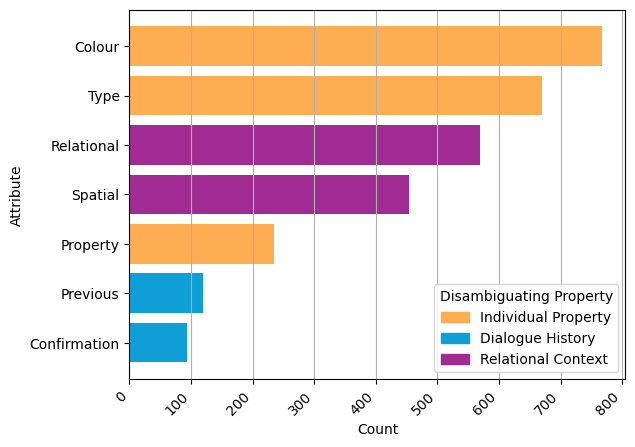

In [7]:
# Create a histogram comparing the most common tags using matplotlib
tag_histogram = {}
tag_counts = []
for ce in clarification_exchanges:
	for tag in tagging.TAGS:
		tag_histogram[tag] = tag_histogram.get(tag, 0) + ce.is_tag_in_ce(tag)
	tag_counts.append(len([tag for tag in ce.tags if tag in tagging.TAGS]))
	if tag_counts[-1] == 7:
		ce.pretty_print(ignore_counter=True)

import numpy as np
# calculate mean counts
print(f"Mean tag counts: {np.mean(tag_counts)}, Max: {max(tag_counts)}, Min: {min(tag_counts)}, SD: {np.std(tag_counts)}, {np.median(tag_counts)=}")

tag_histogram = dict(sorted(tag_histogram.items(), key=lambda item: item[1], reverse=False))

# Map tags to colors
color_map = {}
colors = ['#ffad52', '#0f9ed5', '#a02c93']  # softorange, softblue, pastelpurple
for i, (collection, tags) in enumerate(tagging._TAG_COLLECTION.items()):
    for tag in tags:
        color_map[tag] = colors[i]

# Assign colors to the bars
bar_colors = [color_map.get(tag, 'gray') for tag in tag_histogram.keys()]

# now in matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.barh([x.title() for x in tag_histogram.keys()], list(tag_histogram.values()), color=bar_colors)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Count')  # Add x-axis title
plt.ylabel('Attribute')  # Add y-axis title
plt.grid(axis='x')  # Add vertical grid lines

# Create custom legend handles
legend_handles = [mpatches.Patch(color=colors[i], label=collection.replace('_', ' ').title()) for i, collection in enumerate(tagging._TAG_COLLECTION.keys())]
legend = plt.legend(handles=legend_handles, title="Disambiguating Property", loc='lower right')
legend.get_title().set_ha('left')
plt.setp(legend.get_title(), ha='left')

plt.savefig("simmc2_attribute_frequency.png", bbox_inches='tight', dpi=200)

plt.show()

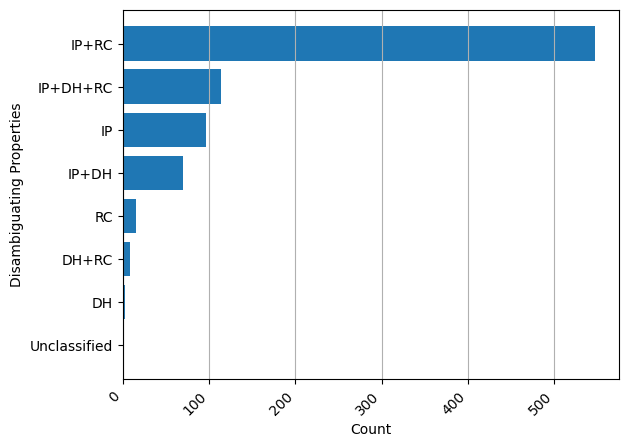

In [8]:
# Create a histogram comparing the most common tags using matplotlib
# do combination of tags
# Create a mapping from each tag to its collection index
tag_to_index = {}
for index, tag in enumerate(tagging._TAG_COLLECTION.keys()):
    tag_to_index[tag] = index

tag_histogram = {}
for ce in clarification_exchanges:
    tags = [x for x in ce.tags if x not in tagging.TAGS]
    # sort by custom order
    tags = sorted(tags, key=lambda x: tag_to_index.get(x, float('inf')))
    tag = '+'.join(tags)
    tag_histogram[tag] = tag_histogram.get(tag, 0) + 1

tag_histogram = dict(sorted(tag_histogram.items(), key=lambda item: item[1], reverse=False)[:20])

# Map tags to colors
# Generate colors using a colormap
num_bars = len(tag_histogram)
colors = plt.cm.rainbow(np.linspace(0, 1, num_bars))

# Assign colors to the bars
bar_colors = [colors[i] for i in range(num_bars)]

# Assign colors to the bars
# bar_colors = [color_map.get(tag, 'gray') for tag in tag_histogram.keys()]

# now in matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.barh([x.replace(tagging.TAG_INDIVIDUAL_PROPERTY, 'IP').replace(tagging.TAG_DIALOGUE_HISTORY, 'DH').replace(tagging.TAG_RELATIONAL_CONTEXT, 'RC').replace(tagging.TAG_OTHER, 'Unclassified') for x in tag_histogram.keys()], list(tag_histogram.values())) #, color=bar_colors)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Count')  # Add x-axis title
plt.ylabel('Disambiguating Properties')  # Add y-axis title
plt.grid(axis='x')  # Add vertical grid lines

# Create custom legend handles
# legend_handles = [mpatches.Patch(color=colors[i], label=collection.replace('_', ' ').title()) for i, collection in enumerate(tagging._TAG_COLLECTION.keys())]
# plt.legend(handles=legend_handles, title="Disambiguating Properties", loc='lower right')
plt.savefig("simmc2_disambiguating_properties_frequency.png", bbox_inches='tight', dpi=200)

plt.show()

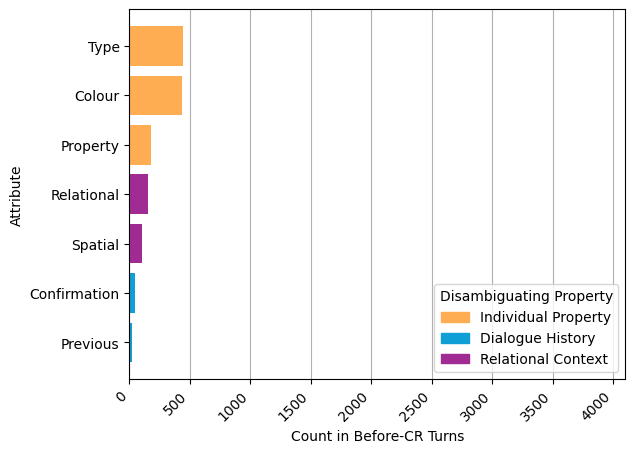

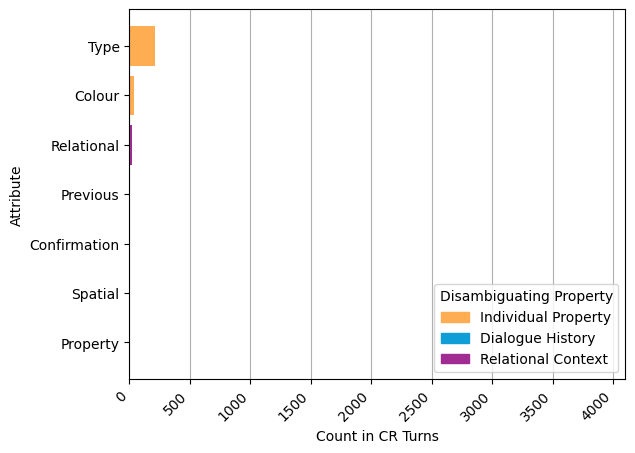

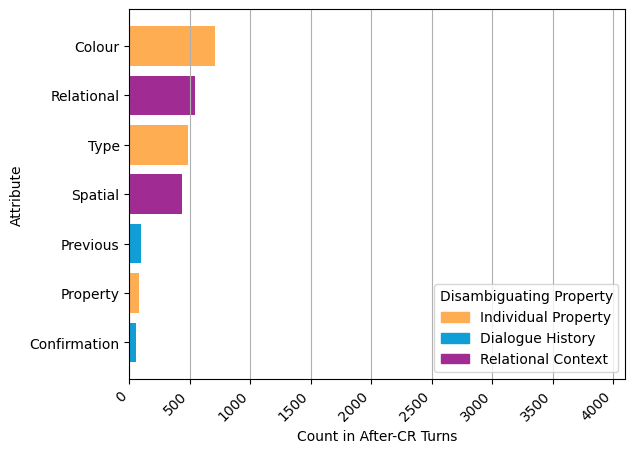

In [9]:
# IGNORE THIS ONE, IT WAS FOR BEFORE vs AFTER CR, BUT RESULTS ARE VERY SIMILAR
# Create a histogram comparing the most common tags using matplotlib
# do combination of tags
# Create a mapping from each tag to its collection index
tag_to_index = {}
for index, tag in enumerate(tagging._TAG_COLLECTION.keys()):
    tag_to_index[tag] = index

def create_barh(target_utterance: str):
	tag_histogram = {}
	for ce in clarification_exchanges:
		for tag in tagging.TAGS:
			tag_histogram[tag] = tag_histogram.get(tag, 0) + (tag in getattr(ce, target_utterance))

	tag_histogram = dict(sorted(tag_histogram.items(), key=lambda item: item[1], reverse=False))

	# Map tags to colors
	color_map = {}
	colors = ['#ffad52', '#0f9ed5', '#a02c93']  # softorange, softblue, pastelpurple
	for i, (collection, tags) in enumerate(tagging._TAG_COLLECTION.items()):
		for tag in tags:
			color_map[tag] = colors[i]

	# Assign colors to the bars
	bar_colors = [color_map.get(tag, 'gray') for tag in tag_histogram.keys()]

	# now in matplotlib
	import matplotlib.pyplot as plt
	import matplotlib.patches as mpatches

	plt.barh([x.title() for x in tag_histogram.keys()], list(tag_histogram.values()), color=bar_colors)
	plt.xticks(rotation=45, ha='right')
	xlabel = "Before-CR" if target_utterance == 'tags_referential_ambiguity' else ("After-CR" if target_utterance == 'tags_c_response' else "CR")
	plt.xlabel(f"Count in {xlabel} Turns")  # Add x-axis title
	plt.ylabel('Attribute')  # Add y-axis title
	plt.grid(axis='x')  # Add vertical grid lines
	plt.xlim(0, 4100)	# Set x-axis limits

	# Create custom legend handles
	legend_handles = [mpatches.Patch(color=colors[i], label=collection.replace('_', ' ').title()) for i, collection in enumerate(tagging._TAG_COLLECTION.keys())]
	legend = plt.legend(handles=legend_handles, title="Disambiguating Property", loc='lower right')
	legend.get_title().set_ha('left')
	plt.setp(legend.get_title(), ha='left')

	plt.savefig(f"simmc2_{target_utterance}.png", bbox_inches='tight', dpi=200)

	plt.show()


# tags_referential_ambiguity, tags_c_request, tags_c_response
for turn_tags in ['tags_referential_ambiguity', 'tags_c_request', 'tags_c_response']:
	create_barh(turn_tags)



In [59]:
# Create the Evaluation Table 2 from the paper by analysing the data and printing to a LaTex format

from src import evaluation

print(f"Evaluation Results Table (Latex)\n{'=' * 24}\n")

def format_row_as_latex(_analysis):
	final_str = []
	for _model_name in all_models:
		if 'Before-CR' in _analysis:
			final_str += [
				f"{format_f1(_analysis['Before-CR'][_model_name]):<14}",
				f"{format_f1(_analysis['After-CR'][_model_name]):<14}",
				f"{format_delta(_analysis['Before-CR'][_model_name], _analysis['After-CR'][_model_name]):<10}"]
		else:
			final_str += [f"\multicolumn{{2}}{{c}}{{{format_f1(_analysis[_model_name])}}} ", ' '*10]

	return ' & '.join(final_str) + ' \\\\'

analysis = {}
for split_name, filter_func in all_splits:
	if split_name == 'All Turns':
		# first time! print headers
		headers = ["\multicolumn{3}{c}{" + x + "}}" for x in all_models]
		subheaders = ['Before-CR     ', 'After-CR      ', '$\\Delta$  '] * len(all_models)
		print(' & '.join(['Model' + ' '*15] + [f"{h:<44}" for h in headers]) + ' \\\\')
		print(f"{' & '.join(['Split' + ' '*15] + subheaders)} \\\\")

	# use the filter func to create a split of the data, then check the results of each model
	analysis[split_name] = evaluation.evaluate_dataset(simmc2_dataset, filter_func)
	column_name = f"{split_name:<20}"
	if '~' not in column_name:
		column_name = f"\\textbf{{{column_name}}}"
	print(f"{column_name} & {format_row_as_latex(analysis[split_name])}")

Evaluation Results Table (Latex)

Model                & \multicolumn{3}{c}{1-Baseline_GPT2}}         & \multicolumn{3}{c}{2-GroundedLan_GPT2}}      & \multicolumn{3}{c}{3-VisLan_LXMERT}}         & \multicolumn{3}{c}{4-MultiTask_BART}}        \\
Split                & Before-CR      & After-CR       & $\Delta$   & Before-CR      & After-CR       & $\Delta$   & Before-CR      & After-CR       & $\Delta$   & Before-CR      & After-CR       & $\Delta$   \\
\textbf{All Turns           } & \multicolumn{2}{c}{34.1 (.01)}  &            & \multicolumn{2}{c}{67.6 (.01)}  &            & \multicolumn{2}{c}{68.3 (.01)}  &            & \multicolumn{2}{c}{73.8 (.01)}  &            \\
\textbf{CR Turns            } & 36.4 (.01)     & 29.1 (.01)     & \colourdelta{-20.1} & 64.8 (.01)     & 67.7 (.01)     & \colourdelta{+4.4} & 65.7 (.01)     & 69.2 (.01)     & \colourdelta{+5.4} & 66.9 (.01)     & 74.3 (.01)     & \colourdelta{+11.1} \\
\textbf{Individual Property } & 35.5 (.01)     & 28.1 (.01)     & 

In [ ]:
# Create the Candidate Objects Table from Appendix A.2
print(f"Candidate Objects Table (Latex)\n{'=' * 23}\n")

headers = ['Split' + ' '*15, 'Mean Candidate Objects Type (SD)  ', 'Mean Candidate Objects Colour (SD)', 'Entries']

for split_name, filter_func in all_splits:
	if split_name == 'All Turns':
		# first time! print headers
		print(f"{' & '.join(headers)} \\\\")

	analysis = evaluation.extract_candidate_objects(simmc2_dataset, simmc2_metadata, simmc2_scenes_jsons, filter_func)

	print(f"{split_name:<20} & {format_mean(analysis['type'])}{' '*23} & {format_mean(analysis['color'])}{' '*23} & {analysis['type']['count']} \\\\")
	# & {format_mean(analysis['brand'])}{' '*22} - used rarely in clarifications, so skipped from table